# Drzewa decyzyjne

### Przygotowanie danych

In [118]:
from sklearn import datasets
data_breast_cancer = datasets.load_breast_cancer(as_frame=True)
print(data_breast_cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

<Axes: xlabel='x', ylabel='y'>

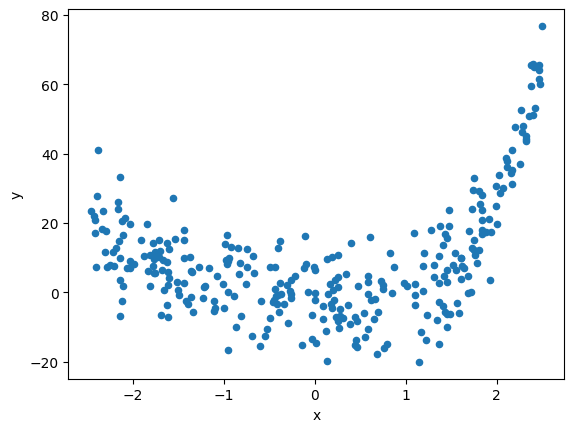

In [119]:
import numpy as np
import pandas as pd
size = 300
X = np.random.rand(size)*5-2.5
w4, w3, w2, w1, w0 = 1, 2, 1, -4, 2
y = w4*(X**4) + w3*(X**3) + w2*(X**2) + w1*X + w0 + np.random.randn(size)*8-4
df = pd.DataFrame({'x':X, 'y':y})
df.plot.scatter(x='x', y='y')

### Klasyfikacja

In [120]:
# Stworzenie osobnego df z danymi, które będą potrzebne
df_breast_cancer = data_breast_cancer['data'][['mean texture', 'mean symmetry']]
df_breast_cancer['target'] = data_breast_cancer['target']
df_breast_cancer

<ipython-input-120-82bc00874f30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_breast_cancer['target'] = data_breast_cancer['target']


,mean texture,mean symmetry,target
0,10.38,0.2419,0
1,17.77,0.1812,0
2,21.25,0.2069,0
3,20.38,0.2597,0
4,14.34,0.1809,0
...,...,...,...
564,22.39,0.1726,0
565,28.25,0.1752,0
566,28.08,0.1590,0
567,29.33,0.2397,0


In [121]:
# Podział na zbiór uczący i testowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_breast_cancer.iloc[:,:2], df_breast_cancer['target'], test_size=0.2, random_state=42)

Trzeba znaleźć parametry (głębokość) drzewa 🌳 aby miało ono jak najlepszy *F-score*:

$F_1 = 2 ⋅ \frac{precision ⋅ recall}{precision + recall} = \frac{2TP}{2TP + FP + FN}$

Do znalezienia najlepszych parametrów użyjemy *GridSearchCV*.

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Testujemy głębokość drzewa od 1 do 10
param_grid = {'max_depth' : range(1,11)}

# Model bazowy
tree = DecisionTreeClassifier(random_state=42)

search = GridSearchCV(tree, param_grid=param_grid, scoring="f1", n_jobs=-1)
search.fit(X_train, y_train)
best_max_depth = search.best_params_['max_depth']
print(f"Najlepsza głębokość to {best_max_depth}")
print(f"Uśrednione najlepsze F1 score dla CAŁEGO zbioru wynosi {search.best_score_}")


Najlepsza głębokość to 2
Uśrednione najlepsze F1 score dla CAŁEGO zbioru wynosi 0.8038301730948788


GridSearch zwraca juz wytrenowany model z najlepszymi parametrami

[Text(0.5, 0.8333333333333334, 'mean texture <= 18.635\ngini = 0.467\nsamples = 455\nvalue = [169, 286]'),
 Text(0.25, 0.5, 'mean symmetry <= 0.18\ngini = 0.249\nsamples = 226\nvalue = [33, 193]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.124\nsamples = 136\nvalue = [9, 127]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.391\nsamples = 90\nvalue = [24, 66]'),
 Text(0.75, 0.5, 'mean symmetry <= 0.172\ngini = 0.482\nsamples = 229\nvalue = [136, 93]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.461\nsamples = 75\nvalue = [27, 48]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.414\nsamples = 154\nvalue = [109, 45]')]

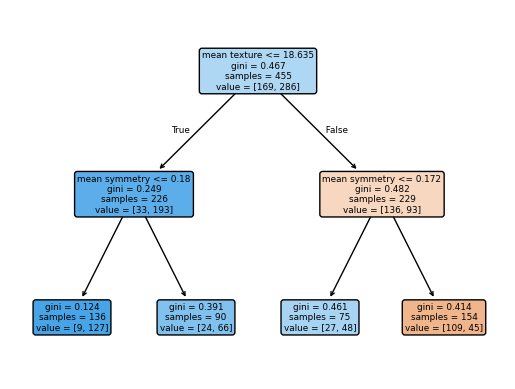

In [123]:
# Wygenerowanie obrazka drzewa
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import graphviz

# nasz model kryje się pod search.best_estimator_
dot_data = export_graphviz(search.best_estimator_, out_file=None, feature_names=df.columns, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("bc", format="png", cleanup=True)

plot_tree(search.best_estimator_, filled=True, rounded=True, feature_names=df_breast_cancer.columns)

In [124]:
# Zapisanie accuracy do pliku
f1_train = f1_score(y_train, search.predict(X_train))
f1_test = f1_score(y_test, search.predict(X_test))
acc_train = accuracy_score(y_train, search.predict(X_train))
acc_test = accuracy_score(y_test, search.predict(X_test))
my_list = [best_max_depth, f1_train, f1_test, acc_train, acc_test]
my_list

[2,
 0.8211243611584327,
 0.7887323943661971,
 0.7692307692307693,
 0.7368421052631579]

In [125]:
import pickle
with open('f1acc_tree.pkl', 'wb') as file:
  pickle.dump(my_list, file)

### Regresja

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df[['x']], df[['y']], test_size = 0.2, random_state=42) #podwójne nawiasy [[]] żeby było df a nie series

In [127]:
from sklearn.tree import DecisionTreeRegressor

param_grid = {'max_depth' : range(1,11)}

#model bazowy
tree_reg = DecisionTreeRegressor(random_state=42)

search = GridSearchCV(tree_reg, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
search.fit(X_train, y_train)
best_max_depth = search.best_params_['max_depth']
print(f"Najlepsza głębokość to {best_max_depth}")
print(f"Uśrednione najlepsze MSE score dla CAŁEGO zbioru wynosi {-search.best_score_}")

Najlepsza głębokość to 4
Uśrednione najlepsze MSE score dla CAŁEGO zbioru wynosi 78.20149598385419


In [128]:
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train, search.predict(X_train))
mse_test = mean_squared_error(y_test, search.predict(X_test))
my_list2 = [best_max_depth, mse_train, mse_test]

with open('mse_tree.pkl', 'wb') as file:
  pickle.dump(my_list2, file)

print(f"MSE train = {mse_train}")
print(f"MSE test = {mse_test}")

MSE train = 63.98903651048968
MSE test = 97.05608582070481


[Text(0.45535714285714285, 0.9, 'x <= 2.012\nsquared_error = 286.071\nsamples = 240\nvalue = 8.444'),
 Text(0.19642857142857142, 0.7, 'x <= -2.148\nsquared_error = 119.739\nsamples = 216\nvalue = 4.161'),
 Text(0.32589285714285715, 0.8, 'True  '),
 Text(0.10714285714285714, 0.5, 'x <= -2.151\nsquared_error = 91.854\nsamples = 16\nvalue = 19.283'),
 Text(0.07142857142857142, 0.3, 'x <= -2.31\nsquared_error = 83.985\nsamples = 15\nvalue = 18.348'),
 Text(0.03571428571428571, 0.1, 'squared_error = 93.958\nsamples = 7\nvalue = 22.48'),
 Text(0.10714285714285714, 0.1, 'squared_error = 47.244\nsamples = 8\nvalue = 14.732'),
 Text(0.14285714285714285, 0.3, 'squared_error = -0.0\nsamples = 1\nvalue = 33.311'),
 Text(0.2857142857142857, 0.5, 'x <= 1.695\nsquared_error = 102.211\nsamples = 200\nvalue = 2.951'),
 Text(0.21428571428571427, 0.3, 'x <= -1.439\nsquared_error = 81.576\nsamples = 185\nvalue = 1.609'),
 Text(0.17857142857142858, 0.1, 'squared_error = 61.056\nsamples = 39\nvalue = 7.514'

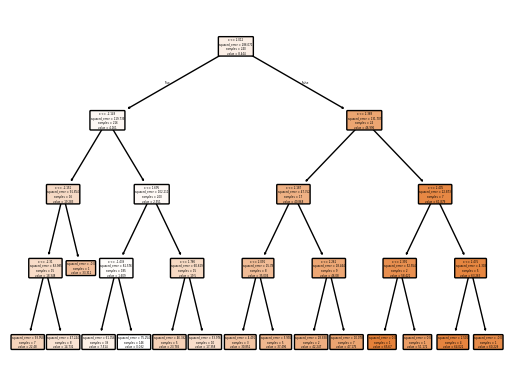

In [129]:
# wygenerowanie rysunku drzewa

dot_data = export_graphviz(search.best_estimator_, out_file=None, feature_names=['x'], filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("reg", format="png", cleanup=True)

plot_tree(search.best_estimator_, filled=True, rounded=True, feature_names=df.columns)

#### Porównanie różnych regressorów

In [130]:
# Zrobienie modeli knn i regresji wielomianowej
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

poly_feature_4 = PolynomialFeatures(degree=4, include_bias=False)
X_poly_4 = poly_feature_4.fit_transform(X_train)
poly_4_reg = LinearRegression()
poly_4_reg.fit(X_poly_4, y_train)

knn_5_reg = KNeighborsRegressor(n_neighbors=5)
knn_5_reg.fit(X_train, y_train)

KNeighborsRegressor()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


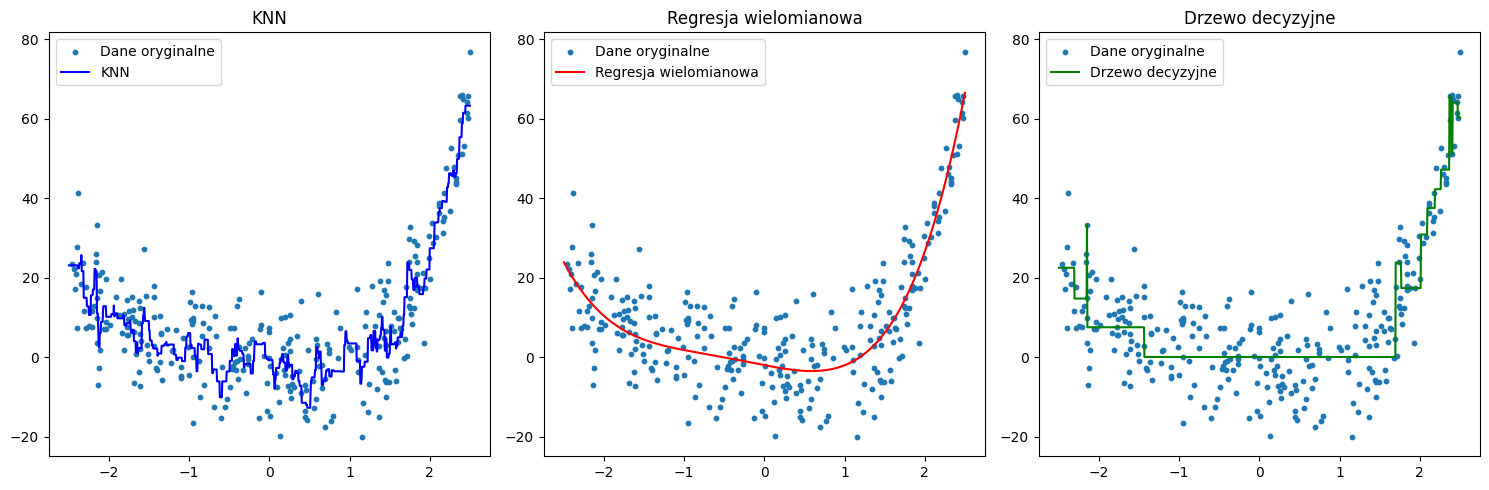

In [131]:
# Wyświetlenie wyników
import matplotlib.pyplot as plt
X_range = np.linspace(-2.5, 2.5, 1000).reshape(-1, 1)
y_knn = knn_5_reg.predict(X_range)
y_poly = poly_4_reg.predict(poly_feature_4.transform(X_range))  # Dla regresji wielomianowej dodatkowo transformacja
y_tree = search.predict(X_range)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 wiersz, 3 kolumny

# Wykres dla KNN
axes[0].scatter(X, y, label='Dane oryginalne', s=10)
axes[0].plot(X_range, y_knn, label='KNN', color='blue')
axes[0].set_title('KNN')
axes[0].legend()

# Wykres dla regresji wielomianowej
axes[1].scatter(X, y, label='Dane oryginalne', s=10)
axes[1].plot(X_range, y_poly, label='Regresja wielomianowa', color='red')
axes[1].set_title('Regresja wielomianowa')
axes[1].legend()

# Wykres dla drzewa decyzyjnego
axes[2].scatter(X, y, label='Dane oryginalne', s=10)
axes[2].plot(X_range, y_tree, label='Drzewo decyzyjne', color='green')
axes[2].set_title('Drzewo decyzyjne')
axes[2].legend()

# Wyświetlenie wykresów
plt.tight_layout()  # Dodaj odstęp między wykresami
plt.show()